---
# Optional: 

- Some more thoughts about stability condition of a FODO cell
- Ellipses and phase space distribution
- Optics matching

---

#### Setup of your Python kernel
Let's load our standard library functions, and setup matplotlib for nice inline plots

In [2]:
# Import custom tracking functions and useful libraries
from tracking_library import *

# Set up plotting
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Exercise 20

Let's go back to our FODO cell (or series of equal FODO cells).
Find the range of focal lengths $f$ for which the FODO cells permit stable oscillations based on the newly introduced condition (i.e. $|Tr(R)| \le 2$)

#### SOLUTION


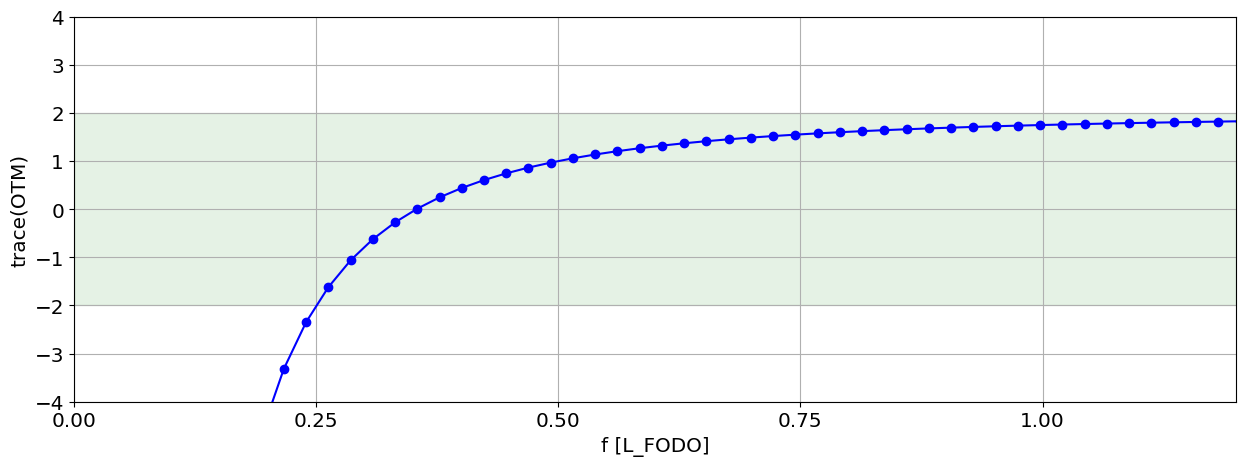

In [3]:
# define a simple function that returns the trace of the equivalent matrix of a FODO cell as a function of L and f
def myOTM_trace(L, f):
    fodo_lattice = Q(2*f) + 10*D(L/10) + Q(-f) + 10*D(L/10) + Q(2*f)
    OTM = getEquivalentElement(fodo_lattice)
    return np.trace(OTM[0]['matrix'])

# define a small function to highlight some portion of a plot [optional]
def setShadedRegion(ax,color='g' ,xLimit=[0,1], yLimit='FullRange',alpha=.1):
    """
    setShadedRegion(ax,color='g' ,xLimit=[0,1],alpha=.1)
    ax: plot axis to use
    color: color of the shaded region
    xLimit: vector with two scalars, the start and the end point
    alpha: transparency settings
    yLimit: if set to "FullRange" shaded the entire plot in the y direction
    If you want to specify an intervall, please enter a two scalar vector as xLimit
    """
    if yLimit == 'FullRange':
        aux = ax.get_ylim()
        plt.gca().fill_between(xLimit, [aux[0],aux[0]],  [aux[1],aux[1]],color=color, alpha=alpha)
        ax.set_ylim(aux)
    else:
        plt.gca().fill_between(xLimit, 
                    [yLimit[0],yLimit[0]],  [yLimit[1],yLimit[1]],color=color, alpha=alpha)


# assume L=2, and then vary f....
L = 2
f_range = np.linspace(.5,5)
plt.plot(f_range/(L*2), [myOTM_trace(L, f) for f in f_range],'-bo')
plt.xlim([0,1.2])
my_xlim = plt.xlim()
setShadedRegion(plt.gca(),xLimit=my_xlim,yLimit=[-2,2])
plt.ylim(-4,4)
plt.xlim(my_xlim);
plt.xticks([0, .25, .5, .75,1])
plt.xlabel('f [L_FODO]')
plt.ylabel('trace(OTM)')
plt.grid(True)

### Exercise 24 (optional)

Consider the usual FODO cell ($f=2.5$, $L=2$), and again a single particle with non-zero initial coordinates (e.g. $x_0 =2.1$; $x' = 2.3$).

Plot again the particle coordinates in phase space for 100 passages along this FODO cell. Then, reverse the polarity of both quadrupoles and repeat. How does the result differ? Why?

#### SOLUTION

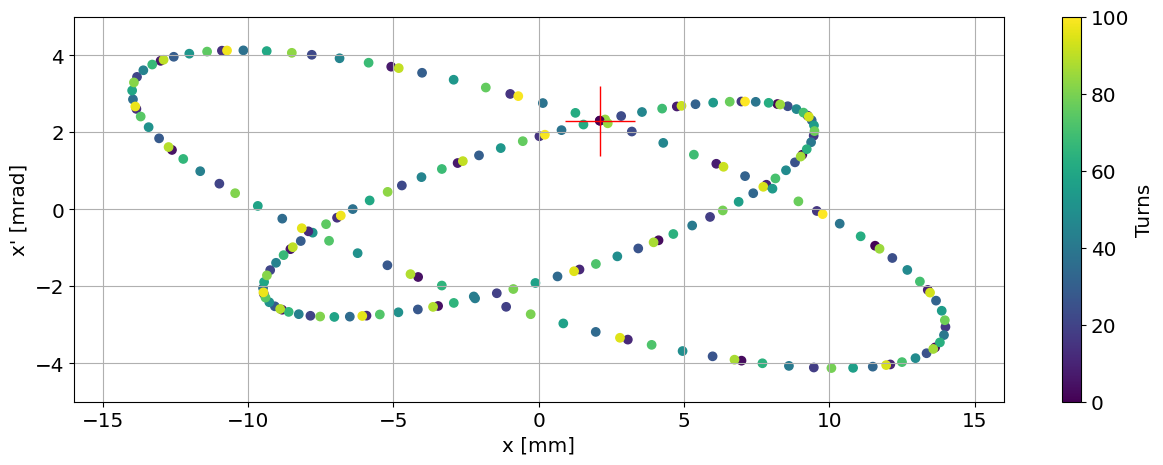

In [16]:
# let's put everything in a simple function
def plotIt(x, xp, f, L):
    particle = [[x],[xp]]
    fodo_cell = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)
    OTM = getEquivalentElement(fodo_cell)
    transported_particles = transportParticles(particle,100*OTM)
    plt.scatter(transported_particles['x'], transported_particles['xp'], c = transported_particles['s']/(L*2))

# a single case
x = 2.1
xp = 2.3
f = 2.5
L = 2
# normal polarity
plotIt(x, xp,  f, L)
# inversed polarity
plotIt(x, xp, -f, L)
# indicate starting point
plt.plot(x, xp,'+r', ms=50)

# add some labels
cb=plt.colorbar()
cb.set_label('Turns')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.xlim(-16,16)
plt.ylim(-5,5)
plt.grid(True)

---

## Ellipses ans Single Particle Emittance

---

It turns out that our particle turn-after-turn stays on an ellipses: 

\begin{equation}
\epsilon = \gamma x^2 + 2 \alpha x x' + \beta x{'\,}^2
\end{equation}

where $(\alpha, \beta, \gamma)$ are the periodic Twiss parameter! and $\epsilon$, in this case, is the **single particle emittance**.

Without entering in the implementation details, two useful functions are defined in our library toolbox: 
- one that can give us the single particle emittance: `particle_emittance(x, xp, beta, alpha)`
- one to give us the coordinate in phase space for an ellipse with the given Twiss and emittance: `ellipse_points(emittance, beta, alpha, n_points = 100)`

In [2]:
from tracking_library import particle_emittance
from tracking_library import ellipse_points

help(particle_emittance)
help(ellipse_points)

Help on function particle_emittance in module tracking_library:

particle_emittance(x, xp, beta, alpha)
    Returns the single particle emittance for a given 
    x, xp particle coordinates and assumed beta and alpha parameters

Help on function ellipse_points in module tracking_library:

ellipse_points(emittance, beta, alpha, n_points=100)
    Returns the x,x' coordinates of an ellipse in phase space for 
    the given Twiss parameters (beta, gamma, emittance)



### Exercise 25

Consider the usual FODO cell, repeated 100 times.
Plot the trajectory, in phase space, of a particle with $x=2$ mm and $x'=1.5$ cell after cell.

Using the functions you have now available, compute the expected periodic solution of our cell, and use this information to:

- compute the single particle emittance
- produce the coordinates in phase space of an ellipse with such an emittance

1. Plot both the tracked particle coordinates and the ellipse in phase space: what do you observe?
2. What happens if you change the sign of the quadrupoles, but don't change the initial particle coordinates? Is there a difference in single particle emittance? Why?

**Optional:** would you be able to predict the exact tracked particle coordinates only from the single cell?

**Hint:** for this last question, one needs to look carefully at the functions implementation details...


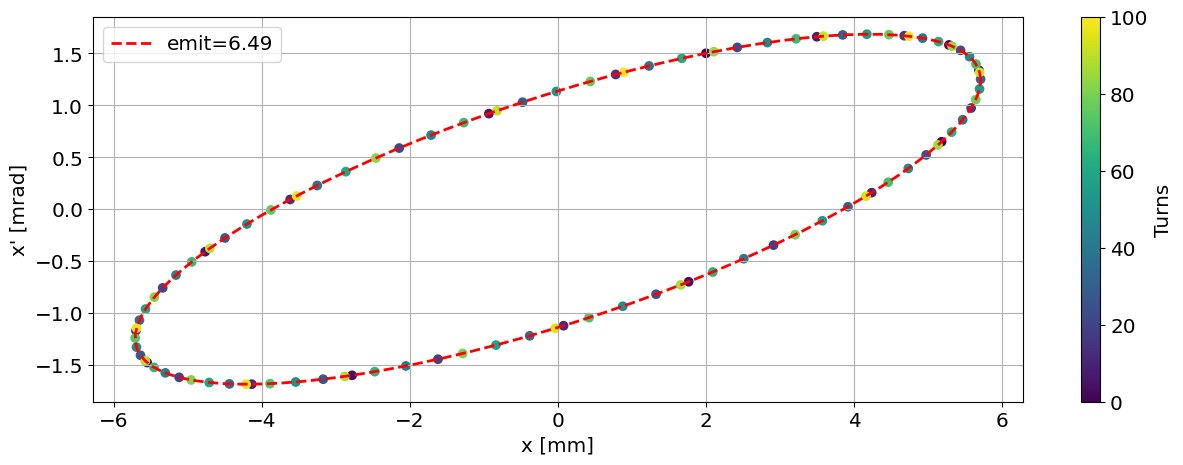

In [23]:
# define our usual FODO cell
f = 2.5
L = 2
fodo_lattice = 5*D(L/10) + Q(f) + 10*D(L/10) + Q(-f) + 5*D(L/10)

# compute the periodic solution
tune, beta, alpha, gamma = twiss(fodo_lattice)

# generate a particle
x = 2
xp = 1.5
particle = [[x],[xp]]

# compute the associate single-particle emittance of this particle
single_part_emit = particle_emittance(x, xp, beta, alpha)
# get coordinate of an ellipse in phase space with the given parameters
ellipse_coordinates = ellipse_points(single_part_emit, beta, alpha)

# track the particle over 100 cells
OTM = getEquivalentElement(fodo_lattice)
transported_particles = transportParticles(particle,100*OTM)

# plot tracked particles as well as ellipse
plt.plot(ellipse_coordinates[0,:], ellipse_coordinates[1,:],'r--', lw=2, label=f'emit={single_part_emit:.2f}')
plt.scatter(transported_particles['x'], transported_particles['xp'], c = transported_particles['s']/(L*2))
cb=plt.colorbar()
cb.set_label('Turns')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.grid(True)
plt.legend()
    


---

## More about effects of thick elements

- Thick quadrupoles
- Bends (2x2 case)

---

### Exercise 30

Consider a FODO cell with 60 degrees/cell phase advance (e.g. $L=f=2$ m) and replace the thin quadrupoles by **thick quadrupoles** with a length of 0.2, 0.4, 1.0 m, while keeping the length of the cell constant.  

- By how much does the periodic beta function at the start of the cell change with a thick lattice with repset to a thin lattice?
- What about the phase advance per cell?

Express the differences in percent. 

- **REQUIREMENT**: You must first implement the element `Qthick` in `tracking_library_advanced.py`, which you might have done already **previous optional exercises**... If not, now is a good time!

#### SOLUTION

In [11]:
from tracking_library_advanced_solution import Qthick

# Thin lens
f = 2
L = 2
fodo_lattice = Q(f) + 10*D(L/10) + Q(-f) + 10*D(L/(10))
tune, beta, alpha, gamma = twiss(fodo_lattice)
beta_thin = beta
tune_thin = tune

# Thick lenses
for l_quad in [.2, .4, 1.0]:
    l_cell = 2*L 
    l_drift = (l_cell-2*l_quad)/2
    k1 = 1/f/l_quad
    fodo_lattice = Qthick(k1,l_quad)+10*D(l_drift/10)+Qthick(-k1,l_quad)+10*D(l_drift/(10))
    tune, beta, alpha, gamma = twiss(fodo_lattice)
    print(f"With l_quad={l_quad} m the thin lens approximation gives us:\n"
            f" {100*(beta-beta_thin)/beta_thin:.1f} % beta-beating!"
            f" {100*(tune-tune_thin)/tune_thin:.1f} % tune-error!")

With l_quad=0.2 m the thin lens approximation gives us:
 -2.1 % beta-beating! -3.7 % tune-error!
With l_quad=0.4 m the thin lens approximation gives us:
 -3.8 % beta-beating! -7.5 % tune-error!
With l_quad=1.0 m the thin lens approximation gives us:
 -6.8 % beta-beating! -19.8 % tune-error!


### Exercise 32

Consider our usual thin FODO cell with 60 degrees/cell phase advance (e.g. $L=f=2$ m). 
Insert now 1 m long dipoles in the center of the drift spaces, while keeping the length of the cell constant.
Investigate deflection angles of $\phi$ = 5, 10 and 20 degrees. 

- By how much the periodic beta function and phase advance of the cell change?

#### SOLUTION 

In [12]:
# Thin lens and no dipoles
f = 2
L = 2
fodo_lattice = Q(f) + 10*D(L/10) + Q(-f) + 10*D(L/(10))
tune, beta, alpha, gamma = twiss(fodo_lattice)
beta_thin = beta
tune_thin = tune

# Thin lens and dipoles
for phi in np.array([5,10,20])*np.pi/180:
    l_cell = 2*L
    l_dipole = 1
    l_drift = (l_cell-l_dipole*2)/4
    fodo_lattice = Q(f) + D(l_drift) + B(phi,l_dipole) + \
                   D(l_drift) + Q(-f) + D(l_drift) + \
                   B(phi,l_dipole) + D(l_drift)
    tune, beta, alpha, gamma = twiss(fodo_lattice)
    print(f"With phi={phi} rad the thin lens approximation gives us:\n"
            f" {100*(beta-beta_thin)/beta_thin:.1f} % beta-beating!"
            f" {100*(tune-tune_thin)/tune_thin:.1f} % tune-error!")


With phi=0.08726646259971647 rad the thin lens approximation gives us:
 -2.7 % beta-beating! 2.9 % tune-error!
With phi=0.17453292519943295 rad the thin lens approximation gives us:
 -9.4 % beta-beating! 11.3 % tune-error!
With phi=0.3490658503988659 rad the thin lens approximation gives us:
 -25.8 % beta-beating! 40.2 % tune-error!


---

## Optics matching

A common task when designing accelerators is matching one section of a beam line to another one...

---

### Exercise 28


Assume to have an upstream beam line that consists of **5 FODO cells with a $60^o$ phase advance** and the downstream beam line of **5 FODO cells with a $90^o$ phase advance.** Assume each cell has $L_{FODO}=2$ m.  

In between the $60^o$ and $90^o,$ place a third cell (total $L=4$ m, for example) with two independent quadrupoles (they might be both focusing or defocusing) that will be used to match the upstream to the downstream beam line.
To do so, we need to prepare periodic beam matrices sigma60 and sigma90 for the respective sections. Note that sigma90 only depends on two parameters: the Twiss parameters $\alpha$ and $\beta,$ and therefore we 
also need two quadrupoles with independently variable focal length to adjust until the final beam matrix equals sigma90.

1. Implement the procedure described in the previous paragraph and match of the FODO lattice with $\mu$=60 deg and the following one with $\mu$=90 deg.
2. Plot the evolution of the sigma matrix elements along the whole beam line (5 FODO cells with $60^o$ phase advance, matching section, 5 FODO cells with $90^o$ phase advance)

**Hint:** This is a tricky exercise. Start with some matching by hand (eventually using interactive plots), then you can try to use some numerical optimiser, e.g. `from scipy.optimize import minimize`


#### SOLUTION

In [4]:
# create two FODO cells with the desired phase advances
L_2 = 2
desired_mu_1 = np.pi/3
desired_mu_2 = np.pi/2

# compute phase advance
f_1 = L_2/(4*np.sin(desired_mu_1/2))
f_2 = L_2/(4*np.sin(desired_mu_2/2))
L = L_2/2

# fodo starting from the middle of a drift
fodo_lattice_1 = 5*D(L/10) + Q(f_1) + 10*D(L/10) + Q(-f_1) + 5*D(L/10)
fodo_lattice_2 = 5*D(L/10) + Q(f_2) + 10*D(L/10) + Q(-f_2) + 5*D(L/10)

In [6]:
# for each fodo lattice, extract the closed Twiss parameters and build the corresponding sigma matrix
tune, beta, alpha, gamma = twiss(fodo_lattice_1)
sigma_60 = np.array([[beta, -alpha],[-alpha, gamma]])

tune, beta, alpha, gamma = twiss(fodo_lattice_2)
sigma_90 = np.array([[beta, -alpha],[-alpha, gamma]])

In [7]:
# optimization by hand 
L_matching = 2
def plotIt(f1, f2):
    #prepare the sigma matrix
    matching_lattice = Q(f1) + 10*D(L_matching/10) + Q(f2) + 10*D(L_matching/10)
    output_b = transportSigmas(sigma_60, 5*fodo_lattice_1 + matching_lattice + 5*fodo_lattice_2)
    
    plt.figure(figsize=(15,6))
    plt.subplot(311)
    plt.plot(output_b['s'], output_b['sigma11'], '-b', lw=3)
    plt.ylabel('sigma11')
    plt.grid(True)
    plt.subplot(312)
    plt.plot(output_b['s'], output_b['sigma22'], '-r', lw=3)
    plt.ylabel('sigma22')
    plt.grid(True)
    plt.subplot(313)    
    plt.plot(output_b['s'], output_b['sigma12'], '-k', lw=3)
    plt.ylabel('sigma12')
    plt.grid(True)
    
interactive_plot = interactive(plotIt,f1=(0,2,.1),f2=(0,2,.1),continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='f1', max=2.0), FloatSlider(value=1.0, description='f…

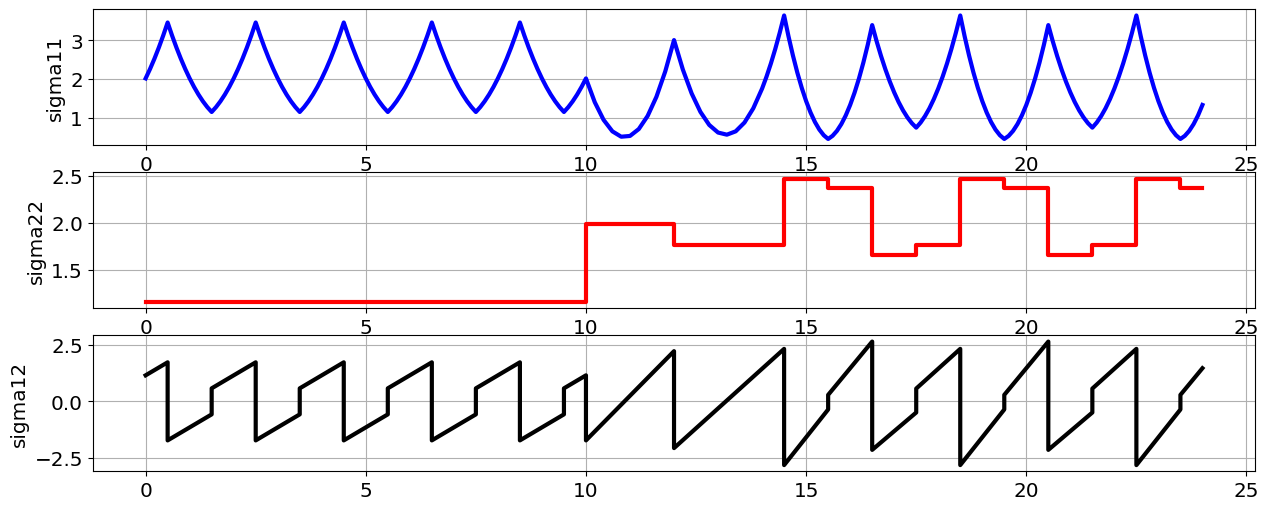

In [8]:
# It turns out that two quad with f=0.7 do the job (more or less)
f1 = 0.7
f2 = 0.7
plotIt(f1, f2)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3.7426018393235105e-08
        x: [ 6.445e-01  7.016e-01]
      nit: 22
      jac: [ 7.508e+00  2.103e+01]
 hess_inv: [[ 2.627e-09  1.525e-10]
            [ 1.525e-10  1.788e-09]]
     nfev: 186
     njev: 58
Actual values are: f1=0.644 and f2=0.702


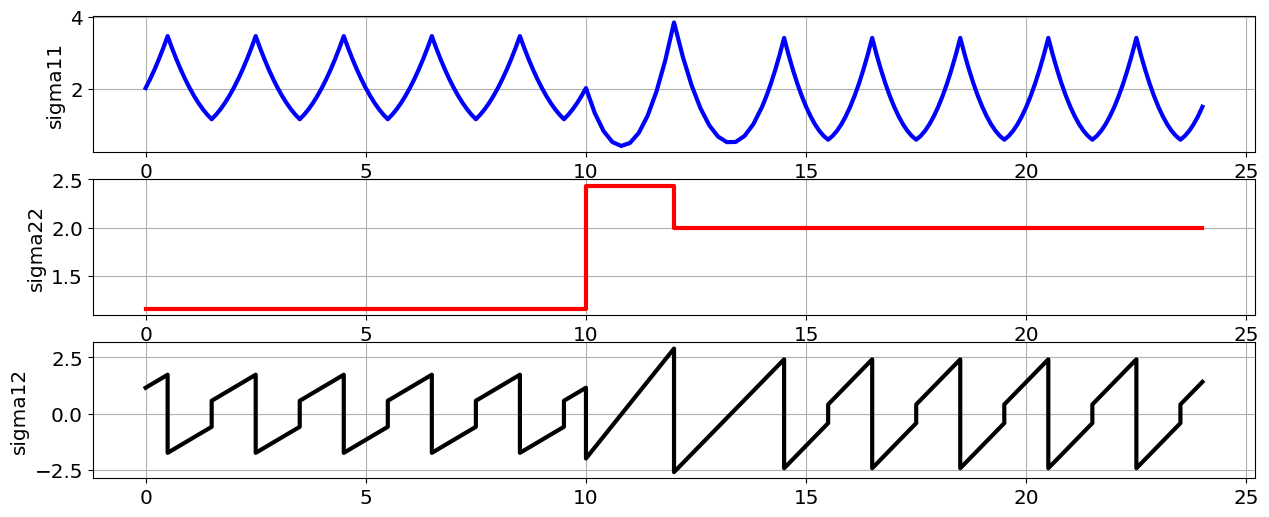

In [9]:
# let's try to use numerical optimisation using scipy.optimize package
from scipy.optimize import minimize
def penalty_function(f):
    matching_lattice = Q(f[0]) + 10*D(L_matching/10) + Q(f[1]) + 10*D(L_matching/10)
    fodo_lattice_compressed = getEquivalentElement(matching_lattice)
    M = fodo_lattice_compressed[0]['matrix']@sigma_60@(fodo_lattice_compressed[0]['matrix']).transpose() - sigma_90
    return np.linalg.norm(M)

res = minimize(penalty_function, [f1, f2])
print(res)

f1 = res['x'][0]
f2 = res['x'][1]
plotIt(f1, f2)
print(f"Actual values are: f1={f1:.3f} and f2={f2:.3f}")